# Summerschool: Social Data Science - Exam Project
## Project: The Trump Twitter Effect
### Group 17. Exam Numbers: 41, 96, 127, 220

*This project studies whether Donald Trump’s sentiment can be used to predict the stock market movements. We conduct a sentiment analysis of his tweets, and uses upervised machine learning to try to predict the Dow Jones stock movement based on his sentiment.*

We start by importing our data source to Python. The file `tweets.json` is created from [the Trump twitter archive](http://www.trumptwitterarchive.com/archive). We have selected all tweets since formal announcement of candidacy.

**DOCSTRING**

Below we provide our docstring to the data project. 
We import the relevant packages, some of which will require installation through either `pip install` or `conda install`. 

In [14]:
'''
DOCSTRING:
Last updated: August 30th 2019.

This project analyzes Donald J. Trump's twitter data and presents a visual analysis of key elements.
It makes use of several packages, some of which should be installed via either pip or conda.
Executing the code cells will save files to the relative path of this Jupyter Notebook. 

'''

# Importing packages
import pandas as pd
import scraping_class, time, json, codecs
import seaborn as sns
import numpy as np
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from IPython.display import display, HTML
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from afinn import Afinn
from fredapi import Fred
from tqdm import tqdm
% matplotlib inline

**Sentiment analyzer**

We have to sentiment analyzers: AFINN and VADER. We define functions for both in the following.
Recall that AFINN ranks the sentence from -5 to 5 and VADER from -1 to 1. 

In [15]:
# Define sentiment analyzer score

# VADER
def sentiment_analyzer_scores(sentence):
    analyser = SentimentIntensityAnalyzer()
    score = analyser.polarity_scores(sentence)
    return score

# AFINN
def afinn_sentiment_analyzer_scores(sentence):
    afinn = Afinn(language='en')
    score = afinn.score(sentence)
    return score

sentence_1 = 'I do love ice cream'
sentence_2 = 'I do not love ice cream'
print('', sentence_1, 'has an AFINN sentiment of', afinn_sentiment_analyzer_scores(sentence_1), '\n',                                                                   
sentence_1, 'has a VADER sentiment of', sentiment_analyzer_scores(sentence_1)['compound'], '\n',
sentence_2, 'has an AFINN sentiment of', afinn_sentiment_analyzer_scores(sentence_2), '\n',
sentence_2, 'has a VADER sentiment of', sentiment_analyzer_scores(sentence_2)['compound'])

 I do love ice cream has an AFINN sentiment of 3.0 
 I do love ice cream has a VADER sentiment of 0.6369 
 I do not love ice cream has an AFINN sentiment of 3.0 
 I do not love ice cream has a VADER sentiment of -0.5216


Based on the results, we see that AFINN is not able to account for the negation, we therefore our analysis continue using only VADER.

### Collecting data

**Trump's tweets**

We set up our connector to the relevant data source and log our connections in a file called *my_log*. 
We later use the log file to visualize our data connection attempts. Next, we scrape the **Trump Twitter Archive** for all tweets from the *@realdonaldtrump* Twitter account.

In [16]:
logfile = 'my_log'## name your log file.
connector = scraping_class.Connector(logfile)
data = []

# Fetching data
for i in range(2015,2020):
    url = 'http://www.trumptwitterarchive.com/data/realdonaldtrump/'+str(i)+'.json'
    r, call_id = connector.get(url, 'Tweets')
    json_file = r.json() 
    data += json_file[::-1] # invert list
    time.sleep(0.5) # set sleep timer to prevent unintentional DOS attacks

**Bloomberg filtered tweets**

Next, we try to collect President Donald Trump's tweets that are relevant to the economy. Bloomberg has already collected these tweets [here](https://www.bloomberg.com/features/trump-tweets-market/).
When trying to fetch the `json` data, we are blocked by Bloomberg. We therefore reside to manually downloading the json text from the `url` and save it into a file called `bloomberg.json`.

In [17]:
# Bloomberg filtered tweets
url = 'https://www.bloomberg.com/bbg-gfx/trump-market-tweets-vs-dow/main.json' # json format
r, call_id = connector.get(url, 'Bloomberg - Tweets')
# json_file = r.json() 
# df_bloom = pd.read_json(json_file)
r.text[:500]

'<!doctype html>\n<html>\n<head>\n    <title>Bloomberg - Are you a robot?</title>\n    <meta name="viewport" content="width=device-width, initial-scale=1">\n    <link rel="stylesheet" type="text/css" href="https://assets.bwbx.io/font-service/css/BWHaasGrotesk-55Roman-Web,BWHaasGrotesk-75Bold-Web,BW%20Haas%20Text%20Mono%20A-55%20Roman/font-face.css">\n    <style rel="stylesheet" type="text/css">\n        html, body, div, span, applet, object, iframe,\n        h1, h2, h3, h4, h5, h6, p, blockquote, pre,\n  '

In [18]:
# load the json file using utf-8 encoding
data_bloom = json.load(codecs.open('bloomberg.json', 'r', 'utf-8-sig'))

**Alpha vantage**

Collecting stock data from the Dow Jones Industrial Average index and S&P 500 using the **Alpha vantage API**.

In [19]:
# Converting the response to datetime
def convert_response(d):
    for dt, prec in d['Time Series (Daily)'].items():
        r = {'datetime':dt}
        r.update(prec)
        yield r

# Looping through DJI and S&P500
indices = {'^DJI':'dji_data_collection','SPX':'sp_data_collection'}
counter = 0
for i,j in indices.items():
    url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol="+i+"&outputsize=full&apikey="
    apikey = "Z6OIONR9OK9RAHMX"
    r, call_id = connector.get(url+apikey, j) #ask for help regarding connector
    if counter == 0:
        data_dji = r.json()
    else:
        data_sp =  r.json()
    counter += 1
    time.sleep(0.5)

In [224]:

def AlphaVantage(data):
    df = pd.DataFrame(convert_response(data))
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime',inplace=True)
    df.sort_index(inplace=True)

    #change the name
    df = df.rename(columns={ '1. open':'dji_open','2. high':'dji_high','3. low':'Low','4. close':'dji_close','5. adjusted close':'dji_adj_close','6. volume':'dji_volume','7. dividend amount':'Dividend amount','8. split coefficient':'Split coefficient'})

    df_dji = df.iloc[:,[0,3,4,5]] #Select only the columns we want


    df_dji['dji_pct_change'] = '' #create empty column to contain pct. change
    r = df_dji['dji_adj_close'].astype(float).pct_change(1) #calculate the change
    df_dji['dji_pct_change'] = r #store the results in the empty column. There should be one row without a value
    # but fortunately that row is outside of our selected window

    df_dji['dji_bool'] = ''

    def pct_bool(df):
        dji_pct_bool = []

        for x in df['dji_pct_change']:
            if x > 0:
                dji_pct_bool.append(1)
            else:
                dji_pct_bool.append(0)

        df["dji_bool"] = dji_pct_bool

    pct_bool(df_dji)

    df_dji_final = df_dji.copy()
    for i in df_dji_final.columns:
        df_dji_final[i] = df_dji_final[i].astype(float)
#     df_dji_final['dji_open'] = df_dji_final['dji_open'].astype(float)
#     df_dji_final['dji_close'] = df_dji_final['dji_close'].astype(float)
#     df_dji_final['dji_adj_close'] = df_dji_final['dji_adj_close'].astype(float)
#     df_dji_final['dji_volume'] = df_dji_final['dji_volume'].astype(float)
#     df_dji_final['dji_bool'] = df_dji_final['dji_bool'].astype(float)

    start_date = '2015-01-01'
    end_date = '2019-08-27'
    df_dji_final = df_dji[start_date:end_date]


    df_dji_final.to_csv('dji.csv')
    return df_dji_final
    



### Data frames

Based on the scraped tweets, we set up our initial data frame. We convert the `datetime` to a readable format including timestamp and index by date. We also remove retweets from our data frame.

In [27]:
### Creating and manipulating dataframes
# Main dataframe
df = pd.DataFrame(data)
date = [i[2]+i[1]+i[-1]+'-'+i[3] for i in df['created_at'].str.split(' ')] # slice date
df['datetime'] = date
df['datetime'] = pd.to_datetime(df['datetime'], format='%d%b%Y-%H:%M:%S') # format datetime 
#df = df[(df['datetime'] > '2017-01-20')] # filter by relevant date
df = df.query("is_retweet == False") # drop retweets
df = df.reset_index(drop=True).sort_values(by=['datetime']) # set index to date
df.index = df['datetime']



In [28]:
# Tweets related to the economy
df_bloom = pd.DataFrame(data_bloom) # load data frame
df_bloom = df_bloom.sort_values(by='timestamp') # chronological order since inception
df_bloom['firstdifference'] = df_bloom['dow'] - df_bloom['dow'].shift() # first DJIA change since last row
df_bloom['relativechange'] = (df_bloom['dow'] - df_bloom['dow'].shift())/df_bloom['dow']*100 # relative change
df_bloom['sentiment'] = [sentiment_analyzer_scores(tweet)['compound'] for tweet in df_bloom['text']] # sentiment (VADER)
date = [i[0]+'-'+i[1][:8] for i in df_bloom['timestamp'].str.split('T')] # slice date
df_bloom['datetime'] = date
df_bloom['datetime'] = pd.to_datetime(df_bloom['datetime'], format='%Y-%m-%d-%H:%M:%S') # format datetime 
df_bloom['datetime']
df_bloom.index = df_bloom['datetime']
display(df_bloom.head())

,dow,id,id_int,text,timestamp,firstdifference,relativechange,sentiment,datetime
datetime,,,,,,,,,
2017-01-20 17:54:36,19827.2500,822502601304526848,822502601304526800,We will bring back our jobs. We will bring bac...,2017-01-20T17:54:36.000Z,NaN,NaN,0.7345,2017-01-20 17:54:36
2017-01-23 11:38:16,19799.8496,823495059010109440,823495059010109400,Busy week planned with a heavy focus on jobs a...,2017-01-23T11:38:16.000Z,-27.4004,-0.138387,0.4939,2017-01-23 11:38:16
2017-01-24 11:11:47,19912.7109,823850781946343427,823850781946343400,Will be meeting at 9:00 with top automobile ex...,2017-01-24T11:11:47.000Z,112.8613,0.566780,0.3382,2017-01-24 11:11:47
2017-01-26 13:55:03,20100.9102,824616644370714627,824616644370714600,of jobs and companies lost. If Mexico is unwil...,2017-01-26T13:55:03.000Z,188.1993,0.936273,-0.5994,2017-01-26 13:55:03
2017-01-30 14:23:49,19971.1309,826073437735100418,826073437735100400,Where was all the outrage from Democrats and t...,2017-01-30T14:23:49.000Z,-129.7793,-0.649835,-0.1531,2017-01-30 14:23:49


Next, we run the sentiment analyzers on our data frame. As there are a lot of tweets this process is quite time consuming.

In [29]:
# Add sentiment to dataframe
df['sentiment'] = [sentiment_analyzer_scores(tweet)['compound'] for tweet in df['text']]
display(df.head())

,created_at,favorite_count,id_str,in_reply_to_user_id_str,is_retweet,retweet_count,source,text,datetime,vader
datetime,,,,,,,,,,
2015-01-01 00:00:26,Thu Jan 01 00:00:26 +0000 2015,33,550441381253382144,None,False,12,Twitter for Android,"""@JaayZen: @realDonaldTrump Thanks Donald. Now...",2015-01-01 00:00:26,0.7494
2015-01-01 00:02:37,Thu Jan 01 00:02:37 +0000 2015,28,550441927964106753,None,False,9,Twitter for Android,"""@teamconquerca: First time in the""Trump Inter...",2015-01-01 00:02:37,0.8711
2015-01-01 00:06:40,Thu Jan 01 00:06:40 +0000 2015,36,550442948375347200,None,False,15,Twitter for Android,"""@AngelaTN777: @gochico @realDonaldTrump: He S...",2015-01-01 00:06:40,0.4738
2015-01-01 00:09:01,Thu Jan 01 00:09:01 +0000 2015,18,550443540111962113,None,False,11,Twitter for Android,"""@JaayZen: @grandmiapens He has all the ingred...",2015-01-01 00:09:01,0.0000
2015-01-01 00:09:47,Thu Jan 01 00:09:47 +0000 2015,17,550443735054839808,None,False,7,Twitter for Android,"""@MarcAardvark: @realDonaldTrump @ronmeier123 ...",2015-01-01 00:09:47,0.6369


### Dow Jones

In [ ]:
df = pd.DataFrame(convert_response(data))
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime',inplace=True)
df.sort_index(inplace=True)


#change the name
df = df.rename(columns={ '1. open':'dji_open','2. high':'dji_high','3. low':'Low','4. close':'dji_close','5. adjusted close':'dji_adj_close','6. volume':'dji_volume','7. dividend amount':'Dividend amount','8. split coefficient':'Split coefficient'})

df_dji = df.iloc[:,[0,3,4,5]] #Select only the columns we want


df_dji['dji_pct_change'] = '' #create empty column to contain pct. change
r = df_dji['dji_adj_close'].astype(float).pct_change(1) #calculate the change
df_dji['dji_pct_change'] = r #store the results in the empty column. There should be one row without a value
# but fortunately that row is outside of our selected window

df_dji['dji_bool'] = ''

def pct_bool(df):
    dji_pct_bool = []

    for x in df['dji_pct_change']:
        if x > 0:
            dji_pct_bool.append(1)
        else:
            dji_pct_bool.append(0)

    df["dji_bool"] = dji_pct_bool

pct_bool(df_dji)

df_dji_final['dji_open'] = df_dji_final['dji_open'].astype(float)
df_dji_final['dji_close'] = df_dji_final['dji_close'].astype(float)
df_dji_final['dji_adj_close'] = df_dji_final['dji_adj_close'].astype(float)
df_dji_final['dji_volume'] = df_dji_final['dji_volume'].astype(float)

start_date = '2017-01-20'
end_date = '2019-08-20'
df_dji_final = df_dji[start_date:end_date]


df_dji_final.to_csv('dji.csv')

In [ ]:

    
# df = pd.DataFrame(convert_response(data))
# df['datetime'] = pd.to_datetime(df['datetime'])
# df.set_index('datetime',inplace=True)
# df.sort_index(inplace=True)


# #change the name
# df = df.rename(columns={ '1. open':'sp_open','2. high':'sp_high','3. low':'Low','4. close':'sp_close','5. adjusted close':'sp_adj_close','6. volume':'sp_volume','7. dividend amount':'Dividend amount','8. split coefficient':'Split coefficient'})

# df_sp = df.iloc[:,[0,3,4,5]] #Select only the columns we want


# df_sp['sp_pct_change'] = '' #create empty column to contain pct. change
# r = df_sp['sp_adj_close'].astype(float).pct_change(1) #calculate the change
# df_sp['sp_pct_change'] = r #store the results in the empty column. There should be one row without a value
# # but fortunately that row is outside of our selected window


# df_sp['sp_bool'] = ''
# def pct_bool(df):
#     sp_pct_bool = []

#     for x in df['sp_pct_change']:
#         if x > 0:
#             sp_pct_bool.append(1)
#         else:
#             sp_pct_bool.append(0)

#     df["sp_bool"] = sp_pct_bool

    
# pct_bool(df_sp)

# df_sp_final['sp_open'] = df_sp_final['sp_open'].astype(float)
# df_sp_final['sp_close'] = df_sp_final['sp_close'].astype(float)
# df_sp_final['sp_adj_close'] = df_sp_final['sp_adj_close'].astype(float)
# df_sp_final['sp_volume'] = df_sp_final['sp_volume'].astype(float)

# start_date = '2017-01-20'
# end_date = '2019-08-20'
# df_sp_final = df_sp[start_date:end_date]



# df_sp_final.to_csv('sp.csv')

In [ ]:
# df_final = pd.concat([df_dji_final,df_sp_final],axis=1)

In [ ]:
plt.subplot(1, 2, 1)
dji_adj_close.plot(y = df_final['dji_adj_close'], figsize=(15,5),color='green', label='Dow Jones Index');
plt.xlabel('Date');plt.ylabel('Dow Jones Index'); 

plt.subplot(1, 2, 2)
sp_adj_close.plot(y = df_final['sp_adj_close'], figsize=(15,5), label='S&P 500 Index');
plt.xlabel('Date');plt.ylabel('S&P 500 Index'); 

plt.show()

In [30]:
print('Since', df.index[0], 'Mr. Trump has made', len(df), 'tweets')

# keywords = ['tariff','trade war','trade'] #List of keywords in lowercase

# results = {} #Dictionary to store results
# for key in keywords:
#     print('Sum of tweets containing', key, ':', sum(df['text'].str.contains('(?i)'+str(key))))
#     results[key]=sum(df['text'].str.contains('(?i)'+str(key))) #Saving the sum of tweets (ignoring case) containing the key

# result_count = {} # empty dictionary to store results
# for key in keywords:
#     count_=0 #resetting the counter
#     for i in range(len(df['text'])): # Looping through all the rows of tweets
#         if key in df['text'][i].lower(): # Checking for the key in  the i'th tweet (in lowercase)
#             count_ += df['text'][i].lower().count(key) # given the key is found we count the number of times it occurs
#         result_count[key]=count_ # Store the count for a given key in the dictionary

# print(result_count)      

Since 2015-01-01 00:00:26 Mr. Trump has made 19632 tweets


In [22]:
# #print(df['text'].resample('M').count())
# #print(df['text'].resample('M').count().sum())

# # search for keywords while ignoring word case (upper/lower)
# df['keyword'] = df['text'].str.contains('(?i)|'.join(keywords)) 
# df_filter = df.query("keyword == True") # filter to contain keywords

# # Creating figure
# ax = plt.gca()
# ax = df['text'].resample('M').count().plot(figsize = (10,5), rot = 45, legend=True)
# ax1 = plt.gca()
# ax1 = df_filter['text'].resample('M').count().plot(figsize = (10,5), rot = 45, secondary_y=True, legend=True)
# # Formatting
# ax.xaxis.label.set_visible(False) # remove axis label
# ax.spines['right'].set_visible(False) # remove right spine
# ax.spines['top'].set_visible(False) # remove top spine
# ax1.spines['top'].set_visible(False) # remove top spine
# ax.xaxis.set_ticks_position('none') # remove ticks from axis
# plt.tight_layout() # prevents cutting off labels
# plt.savefig('monthlytweets.png')
# plt.show()



In [23]:
# results_time = {}
# keywords = ['new york times','nyt']
# ax = plt.gca()

# # Creating figure
# for key in keywords:
#     results_time[key] = df['text'].str.contains('(?i)'+str(key)).resample('M').sum()
#     ax = df['text'].str.contains('(?i)'+str(key)).resample('M').sum().plot(label=key,
#         ax=ax, figsize = (10,5), rot = 45)

# # Formatting
# ax.xaxis.label.set_visible(False) # remove axis label
# ax.spines['right'].set_visible(False) # remove right spine
# ax.spines['top'].set_visible(False) # remove top spine
# ax.xaxis.set_ticks_position('none') # remove ticks from axis
# plt.tight_layout() # prevents cutting off labels
# plt.legend()      
# plt.savefig('keywords.png')
# plt.show()

**Wordcloud**

Using the `wordcloud` package for Python we visualize the most frequently used words, both for all his collective tweets and tweets related to the economy.

In [ ]:
# Define functions to display multiple tables
def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )
# # Fetching trade balance data
# url = 'https://www.census.gov/foreign-trade/balance/c5700.html'
# r, call_id = connector.get(url,'trade_balance') # connecting and saving connection to log file
# dfs = pd.read_html(url) # read the tables
#multi_table(dfs[0:4])  # display

In [31]:
#WORDCLOUD

# function to get custom color for wordcloud
def custom_color(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    h = 30 # int(360.0 * 45.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(100, 160)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)
 
# picture used as shape
trump_mask = np.array(Image.open("trump_mask.jpg")) # read image
trump_mask_T = np.array(Image.open("trump_mask.jpg").transpose(Image.FLIP_LEFT_RIGHT)) # read image transposed

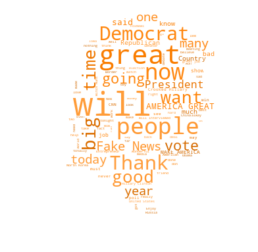

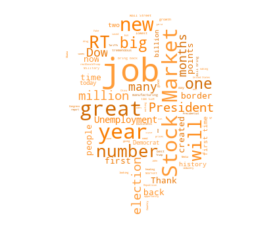

In [60]:
# wordcloud for ALL TWEETS
text = " ".join(tweet for tweet in df['text'][df['text'].str.contains(r'^(?:(?!https|co|amp|realDonaldTrump|Trump).)*$')])

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white",mask=trump_mask, 
                      contour_color ='black',color_func=custom_color).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud.to_file("wordcloud_all.png") # save file

# wordcloud for BLOOMBERG tweets

text = " ".join(tweet for tweet in df_bloom['text'][df_bloom['text'].str.contains(r'^(?:(?!https|co|amp).)*$')])

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white",mask=trump_mask_T, 
                      contour_color ='black',color_func=custom_color).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud.to_file("wordcloud_bloom.png") # save file



In [33]:
# # Define functions to display multiple tables
# def multi_table(table_list):
#     ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
#     '''
#     return HTML(
#         '<table><tr style="background-color:white;">' + 
#         ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
#         '</tr></table>'
#     )
# # Fetching trade balance data
# url = 'https://www.census.gov/foreign-trade/balance/c5700.html'
# r, call_id = connector.get(url,'trade_balance') # connecting and saving connection to log file
# dfs = pd.read_html(url) # read the tables
# multi_table(dfs[0:4])  # display

In [34]:
# # display latex code
# for i in range(4):
#     print(dfs[i].to_latex(index=False))

In [35]:
# df_trade = pd.concat([dfs[i][:-1] for i in range(4)][::-1]) # removing "total" and concatenating data frames

# # Plotting figure
# ax = plt.gca()
# df_trade.plot(kind='line',x='Month',y='Balance', color='red', ax=ax, figsize = (10,5), rot = 35, legend=False)
# ax.xaxis.label.set_visible(False) # remove axis label
# ax.spines['right'].set_visible(False) # remove right spine
# ax.spines['top'].set_visible(False) # remove top spine
# ax.xaxis.set_ticks_position('none') # remove ticks from axis
# plt.tight_layout() # prevents cutting off labels
# plt.savefig('tradebalance.png')
# plt.show()

In [36]:
# ax = plt.gca()
# ax1 = plt.gca()
# df['vader'].resample('W').mean().plot(figsize = (10,5), rot = 45, secondary_y=True, legend=True, ax=ax, linestyle=':',color='orange')
# df['afinn'].resample('W').mean().plot(figsize = (10,5), rot = 45, secondary_y=False, legend=True, linestyle=':',color='blue')
# #ax1 = df_djia.plot(ax = ax1, legend=False)
# ax.xaxis.label.set_visible(False) # remove axis label
# ax.spines['right'].set_visible(False) # remove right spine
# ax.spines['top'].set_visible(False) # remove top spine
# ax1.spines['top'].set_visible(False) # remove top spine
# ax.xaxis.set_ticks_position('none') # remove ticks from axis
# plt.tight_layout() # prevents cutting off labels
# plt.savefig('AFINNVADER.png')
# plt.show()

In [246]:
# Import data from the FRED database using the fredapi
fred = Fred(api_key='6d24e44a9ba97a55ef9b9cea11a5a9b2') # connecting using our FRED api key given by FRED.
data = fred.get_series('VXDCLS')#  CBOE DJIA Volatility Index (VXDCLS)

In [37]:
# # COMPARE VIX AND SENTIMENT
# df_vix = pd.DataFrame(data)
# df_vix.index = pd.to_datetime(df_vix.index)
# start_date = '01/01/2015'
# series = (df_vix.index >= start_date)
# df_vix = df_vix.loc[series]
# df_vix.columns = ['VXDCLS']
# ax = plt.gca()
# ax1 = plt.gca()
# df['vader'].resample('W').mean().plot(figsize = (10,5), rot = 45, secondary_y=True, legend=True, ax=ax, linestyle=':',color='orange')
# ax1 = df_vix.plot(ax = ax1, legend=True)
# ax.xaxis.label.set_visible(False) # remove axis label
# ax.spines['right'].set_visible(False) # remove right spine
# ax.spines['top'].set_visible(False) # remove top spine
# ax1.spines['top'].set_visible(False) # remove top spine
# ax.xaxis.set_ticks_position('none') # remove ticks from axis
# plt.tight_layout() # prevents cutting off labels
# plt.savefig('VXDCLS.png')
# plt.show()





In [38]:
# data = fred.get_series('DJIA')# Dow Jones Industrial Average (DJIA)
# # COMPARE DJI AND SENTIMENT
# df_djia = pd.DataFrame(data)
# df_djia.index = pd.to_datetime(df_djia.index)
# start_date = '01/01/2015'
# series = (df_djia.index >= start_date)
# df_djia = df_djia.loc[series]
# df_djia.columns = ['DJIA']
# ax = plt.gca()
# ax1 = plt.gca()
# df['vader'].resample('W').mean().plot(figsize = (10,5), rot = 45, secondary_y=True, legend=True, ax=ax, linestyle=':',color='orange')
# ax1 = df_djia.plot(ax = ax1, legend=True)

# ax.xaxis.label.set_visible(False) # remove axis label
# ax.spines['right'].set_visible(False) # remove right spine
# ax.spines['top'].set_visible(False) # remove top spine
# ax1.spines['top'].set_visible(False) # remove top spine
# ax.xaxis.set_ticks_position('none') # remove ticks from axis
# plt.tight_layout() # prevents cutting off labels
# plt.savefig('DJIA.png')
# plt.show()

In [39]:
# data = fred.get_series('DTWEXM')#Trade Weighted U.S. Dollar Index: Major Currencies, Goods (DTWEXM)
# # COMPARE Major currencies basket AND SENTIMENT
# df_curr = pd.DataFrame(data)
# df_curr.index = pd.to_datetime(df_curr.index)
# start_date = '01/01/2015'
# series = (df_curr.index >= start_date)
# df_curr = df_curr.loc[series]
# df_curr.columns = ['DTWEXM']
# ax = plt.gca()
# ax1 = plt.gca()
# df['vader'].resample('W').mean().plot(figsize = (10,5), rot = 45, secondary_y=True, legend=True, ax=ax, linestyle=':',color='orange')
# ax1 = df_curr.plot(ax = ax1, legend=True)

# ax.xaxis.label.set_visible(False) # remove axis label
# ax.spines['right'].set_visible(Falbse) # remove right spine
# ax.spines['top'].set_visible(False) # remove top spine
# ax1.spines['top'].set_visible(False) # remove top spine
# ax.xaxis.set_ticks_position('none') # remove ticks from axis
# plt.tight_layout() # prevents cutting off labels
# plt.savefig('Currency.png')
# plt.show()

In [40]:
# data = fred.get_series('DEXCHUS')#Trade Weighted U.S. Dollar Index: Major Currencies, Goods (DTWEXM)
# # COMPARE Major currencies basket AND SENTIMENT
# df_curr = pd.DataFrame(data)
# df_curr.index = pd.to_datetime(df_curr.index)
# start_date = '01/01/2015'
# series = (df_curr.index >= start_date) 
# df_curr = df_curr.loc[series]
# df_curr.columns = ['DEXCHUS']
# ax = plt.gca()
# ax1 = plt.gca()
# df['vader'].resample('W').mean().plot(figsize = (10,5), rot = 45, secondary_y=True, legend=True, ax=ax, linestyle=':',color='orange')
# ax1 = df_curr.plot(ax = ax1, legend=True)

# ax.xaxis.label.set_visible(False) # remove axis label
# ax.spines['right'].set_visible(False) # remove right spine
# ax.spines['top'].set_visible(False) # remove top spine
# ax1.spines['top'].set_visible(False) # remove top spine
# ax.xaxis.set_ticks_position('none') # remove ticks from axis
# plt.tight_layout() # prevents cutting off labels
# plt.savefig('USDCNY.png')
# plt.show()

In [41]:
# display(df.head())
# start_date = '03/02/2018'
# series = (df.index == start_date) 
# df_tweet = df.loc[series]
# df_tweet
# #tweet = 'When a country (USA) is losing many billions of dollars on trade with virtually every country it does business with, trade wars are good, and easy to win. Example, when we are down \$100 billion with a certain country and they get cute, don’t trade anymore-we win big. It’s easy!''

In [42]:
# import pandas as pd
# import json

# with open('bloomberg2.txt') as jdata:
#     jsondata=json.load(jdata)
#     df_bloom=pd.DataFrame(jsondata)
#     df_bloom['sentiment'] = [sentiment_analyzer_scores(tweet)['compound'] for tweet in df_bloom['text']]
# # import codecs
# # with codecs.open('bloomberg.json', 'r', encoding='utf-8',
# #                  errors='ignore') as fdata:
# #                 my_list = list(fdata)
# #                 my_list = my_list[0]              
# #                 test = my_list[0:]
# #                 #print(test)
# #                 testdump = json.dumps(test)
# #                 my_dict = ast.literal_eval(test)
# # my_dict


In [61]:
print(df_bloom['sentiment'].describe())



count    383.000000
mean       0.320669
std        0.541008
min       -0.973500
25%        0.000000
50%        0.519800
75%        0.789650
max        0.978800
Name: sentiment, dtype: float64


The standard deviation is 277.09 
Number of observations: 383 
Outliers are posted here:


,dow,id,id_int,text,timestamp,firstdifference,relativechange,sentiment,datetime,outlier
datetime,,,,,,,,,,
2018-08-22 20:07:29,25733.5996,1032358618576900096,1032358618576900100,Longest bull run in the history of the stock m...,2018-08-22T20:07:29.000Z,1629.7187,6.333038,0.6360,2018-08-22 20:07:29,True
2018-10-16 13:08:24,25798.4199,1052184484941049857,1052184484941049900,“8X more new manufacturing jobs now than with ...,2018-10-16T13:08:24.000Z,-1124.6094,-4.359218,0.0000,2018-10-16 13:08:24,True
2018-11-26 20:20:59,24640.2402,1067151249668214793,1067151249668214800,"....starts today, election is on December 4th....",2018-11-26T20:20:59.000Z,-1072.1504,-4.351217,0.6239,2018-11-26 20:20:59,True
2018-12-24 15:55:22,21792.1992,1077231267559755776,1077231267559755800,The only problem our economy has is the Fed. T...,2018-12-24T15:55:22.000Z,-2025.2403,-9.293419,0.1007,2018-12-24 15:55:22,True
2018-12-28 12:49:26,23062.4004,1078634025412116480,1078634025412116500,.....close the Southern Border. Bring our car ...,2018-12-28T12:49:26.000Z,1270.2012,5.507671,-0.2062,2018-12-28 12:49:26,True


The standard deviation is 221.34 
Number of observations: 378


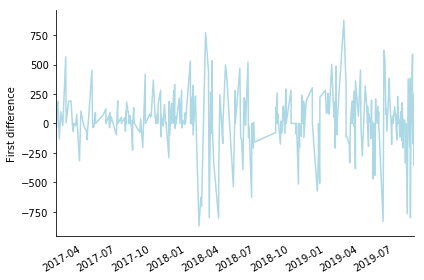

In [67]:
df_bloom['outlier'] = abs(df_bloom['firstdifference']) >= df_bloom['firstdifference'].std()*3.5 # get outliers 3.5 times standard deviation

df_bloom_outlier = df_bloom.query('outlier == True')

print('The standard deviation is', round(df_bloom['firstdifference'].std(),2), '\nNumber of observations:',len(df_bloom),'\nOutliers are posted here:')
display(df_bloom_outlier) # display outliers
df_bloom_clean = df_bloom.query('outlier == False') # remove outliers 

# Plotting figure
fig, ax = plt.subplots()
#df_bloom_clean['dow'].plot(ax=ax,linestyle=':')
print('The standard deviation is', round(df_bloom_clean['firstdifference'].std(),2), '\nNumber of observations:',len(df_bloom_clean))
df_bloom_clean['firstdifference'].plot(ax=ax, color='lightblue')

# Formatting
ax.set_ylabel('First difference')
ax.xaxis.label.set_visible(False) # remove axis label
ax.spines['right'].set_visible(False) # remove right spine
ax.spines['top'].set_visible(False) # remove top spine
ax.xaxis.set_ticks_position('none') # remove ticks from axis
plt.tight_layout() # prevents cutting off labels
#plt.ylabel('First difference', fontsize=10, rotation=90)
plt.savefig('DJIAFD.png')
plt.show()

#plt.show()

In [47]:
#print(df_bloom['sentiment'].describe(), df['vader'].describe())
column_id = ['count', 'mean', 'std', 'min', '25%', '50%', '75%' ,'max']
bloom_desc = list(round(df_bloom['sentiment'].describe(), 2))
All_desc = list(round(df['vader'].describe(),2))
tabledict = {'All tweets': All_desc, 'Selected tweets': bloom_desc}
tableX =  pd.DataFrame(tabledict, index = column_id).T
display(tableX)
display(tableX.to_latex(index=False))

,count,mean,std,min,25%,50%,75%,max
All tweets,19632.0,0.22,0.55,-0.99,-0.1,0.36,0.70,0.99
Selected tweets,383.0,0.32,0.54,-0.97,0.0,0.52,0.79,0.98


'\\begin{tabular}{rrrrrrrr}\n\\toprule\n   count &  mean &   std &   min &  25\\% &   50\\% &   75\\% &   max \\\\\n\\midrule\n 19632.0 &  0.22 &  0.55 & -0.99 & -0.1 &  0.36 &  0.70 &  0.99 \\\\\n   383.0 &  0.32 &  0.54 & -0.97 &  0.0 &  0.52 &  0.79 &  0.98 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [48]:
# df_bloom = df_bloom.reset_index(drop=True)
# df = df.reset_index(drop=True).sort_values(by=['datetime']) # set index to date
date = [i[0]+'-'+i[1][:8] for i in df_bloom['timestamp'].str.split('T')] # slice date
df_bloom['datetime'] = date
df_bloom['datetime'] = pd.to_datetime(df_bloom['datetime'], format='%Y-%m-%d-%H:%M:%S') # format datetime 
df_bloom['datetime']
df_bloom.index = df_bloom['datetime']

In [49]:
df_bloom_Y = df_bloom['sentiment'].groupby(pd.Grouper(freq='Y'))
display(round(df_bloom_Y.describe(),2))
df_Y = df['vader'].groupby(pd.Grouper(freq='Y'))
display(round(df_Y.describe(),2))

,count,mean,std,min,25%,50%,75%,max
datetime,,,,,,,,
2017-12-31,125.0,0.31,0.49,-0.97,0.00,0.42,0.73,0.94
2018-12-31,108.0,0.36,0.53,-0.90,0.00,0.54,0.81,0.98
2019-12-31,150.0,0.30,0.59,-0.97,-0.14,0.54,0.79,0.96


,count,mean,std,min,25%,50%,75%,max
datetime,,,,,,,,
2015-12-31,7536.0,0.26,0.48,-0.97,0.00,0.36,0.67,0.98
2016-12-31,4037.0,0.17,0.54,-0.96,-0.26,0.34,0.62,0.97
2017-12-31,2292.0,0.20,0.58,-0.97,-0.25,0.36,0.72,0.98
2018-12-31,3049.0,0.23,0.63,-0.99,-0.34,0.42,0.80,0.99
2019-12-31,2718.0,0.16,0.63,-0.98,-0.44,0.29,0.73,0.98


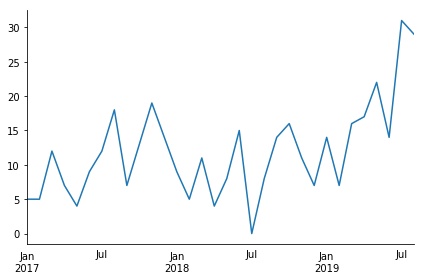

In [51]:
df_bloom['sentiment'].resample('M').count().plot() #secondary_y=True,label='Count',legend=True
#df_bloom['sentiment'].resample('M').mean().plot(label='Sentiment', legend=True)
# df['vader'].resample('M').count().plot(label='All tweets', legend=True)
ax = plt.gca()
ax.xaxis.label.set_visible(False) # remove axis label
ax.spines['right'].set_visible(False) # remove right spine
ax.spines['top'].set_visible(False) # remove top spine
ax.xaxis.set_ticks_position('none') # remove ticks from axis
plt.tight_layout() # prevents cutting off labels      
plt.savefig('CounterSentiments.png')
plt.show()

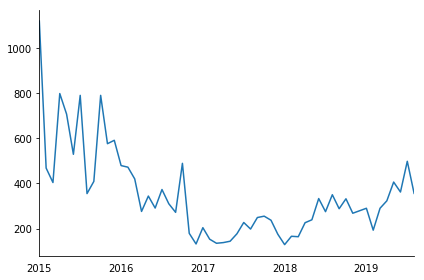

In [72]:
df['vader'].resample('M').count().plot() #secondary_y=True,label='Count',legend=True
#df_bloom['sentiment'].resample('M').mean().plot(label='Sentiment', legend=True)
# df['vader'].resample('M').count().plot(label='All tweets', legend=True)
ax = plt.gca()
ax.xaxis.label.set_visible(False) # remove axis label
ax.spines['right'].set_visible(False) # remove right spine
ax.spines['top'].set_visible(False) # remove top spine
ax.xaxis.set_ticks_position('none') # remove ticks from axis
plt.tight_layout() # prevents cutting off labels      
plt.savefig('AllTweets.png')
plt.show()

In [52]:
df_drop_datetime =df.drop("datetime", axis=1)

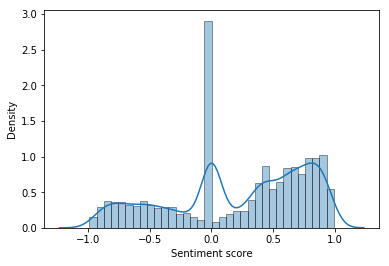

In [70]:

df_sentiment_mean_by_day = df_drop_datetime.groupby('datetime')['vader'].mean()
Sentplot = sns.distplot(df_sentiment_mean_by_day, hist=True, kde=True,
             hist_kws={'edgecolor':'black'})


Sentplot.set_xlabel('Sentiment score')
Sentplot.set_ylabel('Density')
Sentplot.xaxis.label.set_fontsize(10)
Sentplot.yaxis.label.set_fontsize(10)
FigKDE = Sentplot.get_figure()
FigKDE.savefig('KDEPLOT.png')

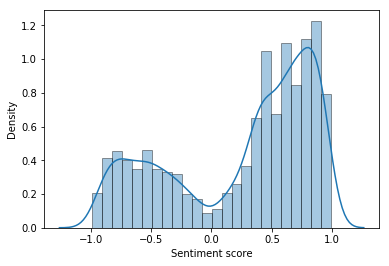

In [71]:
df_drop_null = df_drop_datetime.query('vader!=0')
df_null_sentiment_mean_by_day = df_drop_null.groupby('datetime')['vader'].mean()
Sentplot = sns.distplot(df_null_sentiment_mean_by_day, hist=True, kde=True,
             hist_kws={'edgecolor':'black'})


Sentplot.set_xlabel('Sentiment score')
Sentplot.set_ylabel('Density')
Sentplot.xaxis.label.set_fontsize(10)
Sentplot.yaxis.label.set_fontsize(10)
FigKDE = Sentplot.get_figure()
FigKDE.savefig('KDEPLOT2.png')

In [55]:
df_bloom_drop_datetime =df_bloom.drop("datetime", axis=1)

,dow,id,id_int,text,timestamp,firstdifference,relativechange,sentiment,outlier
datetime,,,,,,,,,
2017-01-20 17:54:36,19827.2500,822502601304526848,822502601304526800,We will bring back our jobs. We will bring bac...,2017-01-20T17:54:36.000Z,NaN,NaN,0.7345,False
2017-01-23 11:38:16,19799.8496,823495059010109440,823495059010109400,Busy week planned with a heavy focus on jobs a...,2017-01-23T11:38:16.000Z,-27.4004,-0.138387,0.4939,False
2017-01-24 11:11:47,19912.7109,823850781946343427,823850781946343400,Will be meeting at 9:00 with top automobile ex...,2017-01-24T11:11:47.000Z,112.8613,0.566780,0.3382,False
2017-01-26 13:55:03,20100.9102,824616644370714627,824616644370714600,of jobs and companies lost. If Mexico is unwil...,2017-01-26T13:55:03.000Z,188.1993,0.936273,-0.5994,False
2017-01-30 14:23:49,19971.1309,826073437735100418,826073437735100400,Where was all the outrage from Democrats and t...,2017-01-30T14:23:49.000Z,-129.7793,-0.649835,-0.1531,False
2017-02-03 11:41:11,20071.4609,827482059438432260,827482059438432300,Meeting with biggest business leaders this mor...,2017-02-03T11:41:11.000Z,100.3300,0.499864,0.7500,False
2017-02-08 19:22:33,20054.3398,829410107406614534,829410107406614500,"Thank you Brian Krzanich, CEO of @Intel. A gre...",2017-02-08T19:22:33.000Z,-17.1211,-0.085374,0.8814,False
2017-02-16 11:34:46,20619.7695,832191485701451777,832191485701451800,Stock market hits new high with longest winnin...,2017-02-16T11:34:46.000Z,565.4297,2.742173,0.9392,False
2017-02-17 11:38:20,20624.0508,832554772318322688,832554772318322700,"Going to Charleston, South Carolina, in order ...",2017-02-17T11:38:20.000Z,4.2813,0.020759,0.0000,False


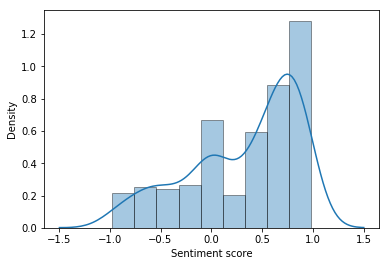

In [69]:
bloom_sentiment_mean_by_day = df_bloom_drop_datetime.groupby('datetime')['sentiment'].mean()
Sentplot = sns.distplot(bloom_sentiment_mean_by_day, hist=True, kde=True,
             hist_kws={'edgecolor':'black'})


Sentplot.set_xlabel('Sentiment score')
Sentplot.set_ylabel('Density')
Sentplot.xaxis.label.set_fontsize(10)
Sentplot.yaxis.label.set_fontsize(10)
FigKDE = Sentplot.get_figure()
FigKDE.savefig('KDEPLOTBLOOM.png')

By removing tweets with a sentiment score of zero, we have removed 3227 tweets
By removing tweets with a sentiment score of zero, we have removed 40 tweets


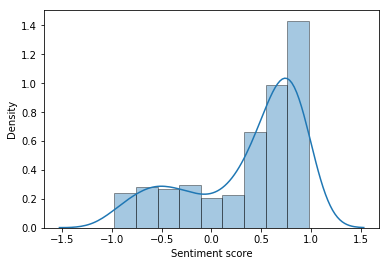

In [68]:
df_bloom_drop_null = df_bloom_drop_datetime.query('sentiment!=0')
bloom_null_sentiment_mean_by_day = df_bloom_drop_null.groupby('datetime')['sentiment'].mean()
Sentplot = sns.distplot(bloom_null_sentiment_mean_by_day, hist=True, kde=True,
             hist_kws={'edgecolor':'black'})


Sentplot.set_xlabel('Sentiment score')
Sentplot.set_ylabel('Density')
Sentplot.xaxis.label.set_fontsize(10)
Sentplot.yaxis.label.set_fontsize(10)
FigKDE = Sentplot.get_figure()
FigKDE.savefig('KDEPLOT2BLOOM.png')

print('By removing tweets with a sentiment score of zero, we have removed', df.shape[0]-df_drop_null.shape[0], 'tweets')
print('By removing tweets with a sentiment score of zero, we have removed', df_bloom.shape[0]-df_bloom_drop_null.shape[0], 'tweets')


### Machine Learning

**Time series split**


,index,Meta Data,Time Series (Daily),time


In [331]:
# Preparing bloomberg tweet data frame
df_bloom_clean = df_bloom.copy()
df_bloom_clean.reset_index(drop=True)
df_bloom_clean['time'] =  range(0,df_bloom_clean['datetime'].count())
df_bloom_clean['datetime'] = df_bloom_clean['datetime'].dt.date # format datetime
df_bloom_clean = df_bloom_clean.set_index('datetime',drop=True)
df_bloom_clean = df_bloom_clean.dropna()
df_merge = pd.merge(df_dji, df_bloom_clean, left_index=True, right_index=True)
display(df_bloom_clean.head(3))
features = ['time','sentiment']
display(df_merge[features].head())

,dow,id,id_int,text,timestamp,firstdifference,relativechange,sentiment,outlier,time
datetime,,,,,,,,,,
2017-01-23,19799.8496,823495059010109440,823495059010109400,Busy week planned with a heavy focus on jobs a...,2017-01-23T11:38:16.000Z,-27.4004,-0.138387,0.4939,False,1
2017-01-24,19912.7109,823850781946343427,823850781946343400,Will be meeting at 9:00 with top automobile ex...,2017-01-24T11:11:47.000Z,112.8613,0.566780,0.3382,False,2
2017-01-26,20100.9102,824616644370714627,824616644370714600,of jobs and companies lost. If Mexico is unwil...,2017-01-26T13:55:03.000Z,188.1993,0.936273,-0.5994,False,3


,time,sentiment
datetime,,
2017-01-23,1,0.4939
2017-01-24,2,0.3382
2017-01-26,3,-0.5994
2017-01-30,4,-0.1531
2017-02-03,5,0.7500


In [300]:
# #df.rename(columns={'vader':'sentiment'},inplace=True)
# df_all = df.copy()
# del df_dji
# df_dji = AlphaVantage(data_dji)
# for i in df_dji.columns:
#     df_dji[i] = df_dji[i].astype(float)

# df_all['datetime'] = df_all['datetime'].dt.date # format datetime
# df_all = df_all.set_index(df_all['datetime'],drop=True)
# df_merge = pd.merge(df_all, df_bloom, left_index=True, right_index=True)
# df_merge['time'] =  range(0,df_merge['datetime'].count())
# df_merge = df_merge.set_index('time')
# features = ['time','sentiment','retweet_count','favorite_count','dji_volume','dji_open']
# display(df_merge[features].head())

C:\Users\bjorn\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\bjorn\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\bjorn\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

,time,sentiment,retweet_count,favorite_count,dji_volume,dji_open
datetime,,,,,,
2015-01-02,0,0.0000,19,43,76270000.0,17823.0703
2015-01-02,1,0.4767,39,116,76270000.0,17823.0703
2015-01-02,2,0.8475,66,104,76270000.0,17823.0703
2015-01-02,3,0.7708,13,41,76270000.0,17823.0703
2015-01-02,4,0.3182,1887,1795,76270000.0,17823.0703


Observations: 130
Training Observations: 67
Testing Observations: 63
Observations: 193
Training Observations: 130
Testing Observations: 63
Observations: 256
Training Observations: 193
Testing Observations: 63
Observations: 319
Training Observations: 256
Testing Observations: 63
Observations: 382
Training Observations: 319
Testing Observations: 63


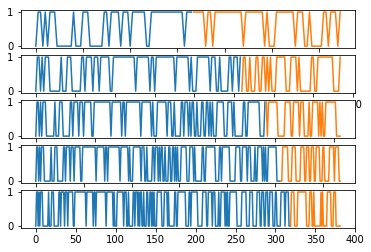

In [332]:
import statsmodels.api as sm
from matplotlib import pyplot

import requests

import sklearn
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve, validation_curve, TimeSeriesSplit, train_test_split
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

X1 = df_merge[features].values # features
X = sm.add_constant(X1)
splits = TimeSeriesSplit(n_splits=5)

for train_index, test_index in splits.split(X):
	X_train = X[train_index]
	X_test = X[test_index]
pyplot.show()

Y = df_merge['dji_bool'].values # bloomberg tweets
splits = TimeSeriesSplit(n_splits=5)
pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(Y):
	y_train = Y[train_index]
	y_test = Y[test_index]
	print('Observations: %d' % (len(y_train) + len(y_test)))
	print('Training Observations: %d' % (len(y_train)))
	print('Testing Observations: %d' % (len(y_test)))
	pyplot.subplot(510 + index)
	pyplot.plot(y_train)
	pyplot.plot([None for i in y_train] + [x for x in y_test])
	index += 1
pyplot.show()

In [333]:
reg=linear_model.LinearRegression()
reg.fit(X_train, y_train)
reg.coef_
a=reg.predict(X_test)
print('RMSE:',(np.mean((a-y_test)**2))**1/2)

# R Squared
print('R-squared:',sklearn.metrics.r2_score(y_test, a))

RMSE: 0.12836713102857797
R-squared: -0.03344653763169547


In [348]:
Y = df_merge['dji_bool'].values # bloomberg tweets
ols_model = sm.OLS(Y, X)
ols_results = ols_model.fit()
res = ols_results.summary()
res.as_latex() # print to latex format
print(res)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     2.973
Date:                Tue, 27 Aug 2019   Prob (F-statistic):             0.0524
Time:                        12:46:05   Log-Likelihood:                -268.49
No. Observations:                 382   AIC:                             543.0
Df Residuals:                     379   BIC:                             554.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6973      0.053     13.220      0.0

In [335]:
pipe_preproc = make_pipeline(PolynomialFeatures(), StandardScaler())

# apply preproc - fit on train
pipe_preproc.fit(X_train) # fit to training
X_train_prep = pipe_preproc.transform(X_train) # transform training data
X_test_prep = pipe_preproc.transform(X_test) # transform test data


In [336]:
pipe_lr = make_pipeline(PolynomialFeatures(include_bias=False), 
                        StandardScaler(),
                        LinearRegression())

pipe_lr.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

In [337]:
from math import sqrt
perform_las_dj = []
lambdas = np.logspace(-4, 4, 33)
for lambda_ in lambdas:
    pipe_lasso = make_pipeline(PolynomialFeatures(include_bias=False), 
                               StandardScaler(),
                               Lasso(alpha=lambda_, random_state=1))
    pipe_lasso.fit(X_train, y_train)
    y_pred = pipe_lasso.predict(X_train)
    mse1 = mse(y_pred, y_train)
    perform_las_dj.append(mse1**0.5)
    
hyperparam_perform_las_dj = pd.Series(perform_las_dj,index=lambdas)

optimal_las_dj = hyperparam_perform_las_dj.nsmallest(1)    
print(optimal_las_dj)

pipe_lasso = make_pipeline(PolynomialFeatures(include_bias=False), 
                               StandardScaler(),
                               Lasso(alpha=optimal_las_dj.index[0]))
pipe_lasso.fit(X_train,y_train)

0.0001    0.485632
dtype: float64


Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [338]:
las = linear_model.Lasso(alpha=optimal_las_dj.index[0])
las.fit(X_train, y_train)
las.coef_

array([ 0.        , -0.0003159 , -0.03165065])

In [339]:
perform_rid_dj = []
lambdas = np.logspace(-4, 4, 33)
for lambda_ in lambdas:
    pipe_ridge = make_pipeline(PolynomialFeatures(include_bias=False), 
                               StandardScaler(),
                               Ridge(alpha=lambda_, random_state=1))
    pipe_ridge.fit(X_train, y_train)
    y_pred = pipe_ridge.predict(X_train)
    mse2 = mse(y_pred, y_train)
    perform_rid_dj.append(mse2**0.5)
    
hyperparam_perform_rid_dj = pd.Series(perform_rid_dj,index=lambdas)

optimal_rid_dj = hyperparam_perform_rid_dj.nsmallest(1)    
print(optimal_rid_dj)

pipe_ridge = make_pipeline(PolynomialFeatures(include_bias=False), 
                               StandardScaler(),
                               Ridge(alpha=optimal_rid_dj.index[0]))
pipe_ridge.fit(X_train,y_train)

0.0001    0.485632
dtype: float64


Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [340]:
rid = linear_model.Ridge(alpha=optimal_rid_dj.index[0])
rid.fit(X_train, y_train)
rid.coef_

array([ 0.        , -0.00031578, -0.03202364])

In [341]:
print('LinReg', round(sqrt(mse(pipe_lr.predict(X_test),y_test)), 10))
print('Ridge', round(sqrt(mse(pipe_ridge.predict(X_test),y_test)), 10))
print('Lasso', round(sqrt(mse(pipe_lasso.predict(X_test),y_test)), 10))

LinReg 0.4910394917
Ridge 0.4923059405
Lasso 0.4924965267


In [342]:
train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_lasso,
                   X=X_train,
                   y=y_train,
                   train_sizes=np.linspace(0.1, 1.0, 10),
                   scoring='neg_mean_squared_error',                 
                   cv=5)
    
mse_ = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Test':-test_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size'))    
print(mse_.head())

C:\Users\bjorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\bjorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


                Train         Test
sample size                       
25           0.171040  4590.220819
51           0.194987   215.281387
76           0.192168     0.731124
102          0.194498    13.676308
127          0.200678     9.594827


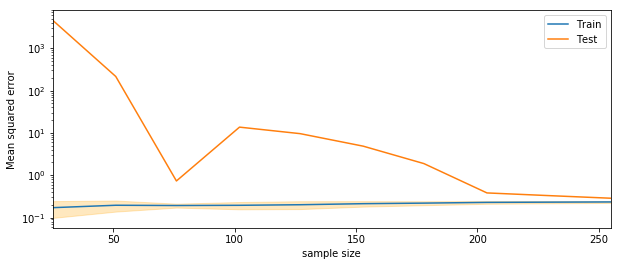

In [343]:
f_learn, ax = plt.subplots(figsize=(10,4))
mse_.plot(ax=ax, logy=True)
ax.fill_between(train_sizes,
                -train_scores.mean(1) + train_scores.std(1)*1.96,
                -train_scores.mean(1) - train_scores.std(1)*1.96, 
                alpha=0.25, 
                color='orange')
ax.set_ylabel('Mean squared error')

f_learn.savefig("Learning Curve.png")